In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

from fastai.callback.hook import ActivationStats
from fastai.data.block import DataBlock, CategoryBlock
from fastai.data.transforms import get_image_files, GrandparentSplitter, parent_label, Normalize
from fastai.metrics import RocAucBinary
from fastai.layers import Flatten, sequential
from fastai.learner import Learner
from fastai.vision.data import ImageBlock

from torch import nn
from torch.nn import functional as F


from pathlib import Path
from kloppy.domain.models import Point
from sklearn.model_selection import train_test_split

from soccer_analytics.data.statsbomb import get_metadata, get_events
from soccer_analytics.data_split import split_by_time

In [ ]:
competitions = get_metadata()

In [ ]:
full_competitions = {
    "1. Bundesliga": ["2015/2016"],
    "FA Women's Super League": ["2018/2019", "2019/2020", "2020/2021"],
    "FIFA World Cup": ["2018", "2022"],
    "Indian Super league": ["2021/2022"],
    "La Liga": ["2015/2016"],
    # "Ligue 1": ["2015/2016"], Not working right now, see https://github.com/statsbomb/open-data/issues/42
    "Premier League": ["2015/2016"],
    "Serie A": ["2015/2016"],
    "UEFA Euro": ["2020"],
    "UEFA Women's Euro": ["2022"],
    "Women's World Cup": ["2019", "2023"]
}

In [ ]:
matches_by_competition = {}
for competition in competitions:
    print(competition.name, len(competition.seasons))
    if competition.name in full_competitions:
        matches_by_competition[competition.name] = []
        for season in competition.seasons:
            print(f"    {season.name}: {len(season.matches)}")
            if season.name in full_competitions[competition.name]:
                matches_by_competition[competition.name].extend(get_events(
                    season, event_types=["shot"]
                ))

In [ ]:
train_matches = []
test_matches = []
validation_matches = []
for competition_name, matches in matches_by_competition.items():
    if len(matches) > 0:
        # out of time validation: last 20% of matches by time in the competition
        competition_train_test_matches, competition_validation_matches = split_by_time(matches, test_frac=0.2)
        # In time test: random 20% of matches from the first 80% of time in the competition:
        competition_train_matches, competition_test_matches = train_test_split(
            competition_train_test_matches, test_size=0.2, random_state=235
        )
        train_matches.extend(competition_train_matches)
        test_matches.extend(competition_test_matches)
        validation_matches.extend(competition_validation_matches)
len(train_matches), len(test_matches), len(validation_matches)

In [ ]:
def make_player_heatmap(location: Point, x_mesh, y_mesh, sigma=1, cutoff=3):
    rs = np.sqrt((location.x - x_mesh)**2 + (location.y - y_mesh)**2)
    heatmap = np.zeros(x_mesh.shape)
    heatmap += np.exp(-0.5 * (rs/sigma)**2)
    heatmap[rs > cutoff] = 0
    return heatmap

def make_shot_heatmap(shot, x_mesh, y_mesh, sigma=1, cutoff=3):
    rgb = np.ones(x_mesh.shape + (3,), dtype=float) * 255
    shooting_team = shot.ball_owning_team
    shooter = shot.player
    for player, location in shot.freeze_frame.players_coordinates.items():
        heatmap = make_player_heatmap(location, x_mesh, y_mesh, sigma=sigma, cutoff=cutoff) * 255
        if player == shooter:
            rgb[:, :, 0] -= heatmap
            rgb[:, :, 1] -= heatmap
        elif player.team != shooting_team:
            if player.position and player.position.name == "Goalkeeper":
                rgb[:, :, 0] -= heatmap
                rgb[:, :, 2] -= heatmap
            else:
                rgb[:, :, 1] -= heatmap
                rgb[:, :, 2] -= heatmap
    rgb[rgb < 0] = 0
    
    return rgb

In [3]:
notebook_dir = Path(os.getcwd())
data_dir = notebook_dir.parent.parent / "data"
image_dir = data_dir / "shot_images"
image_dir

Path('/Users/rook/repos/mine/soccer_analytics/data/shot_images')

In [ ]:
def generate_shot_images(matches, x_mesh, y_mesh, parent_dir):
    num_shots = 0
    for match in matches:
        for shot in match:
            if shot.freeze_frame:  # No freeze frames for PKs
                heatmap = make_shot_heatmap(shot, x_mesh, y_mesh)
                folder = "no_goal" if shot.result.is_success is False else "goal"
                directory = parent_dir / folder 
                directory.mkdir(parents=True, exist_ok=True)
                plt.imsave(directory / (shot.record_id + ".jpg"), heatmap.astype(np.uint8))
                num_shots += 1
    return num_shots

In [ ]:
n_points = 192
x = np.linspace(40, 120, n_points)
y = np.linspace(0, 80, n_points)
x_mesh, y_mesh = np.meshgrid(x, y)

shutil.rmtree(image_dir)
(
    generate_shot_images(train_matches, x_mesh, y_mesh, image_dir / "train"),
    generate_shot_images(test_matches, x_mesh, y_mesh, image_dir / "test"),
    generate_shot_images(validation_matches, x_mesh, y_mesh, image_dir / "validation")
)

In [4]:
def get_dls(path, bs=64):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter("train", "test"),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=64)

dls = get_dls(image_dir)

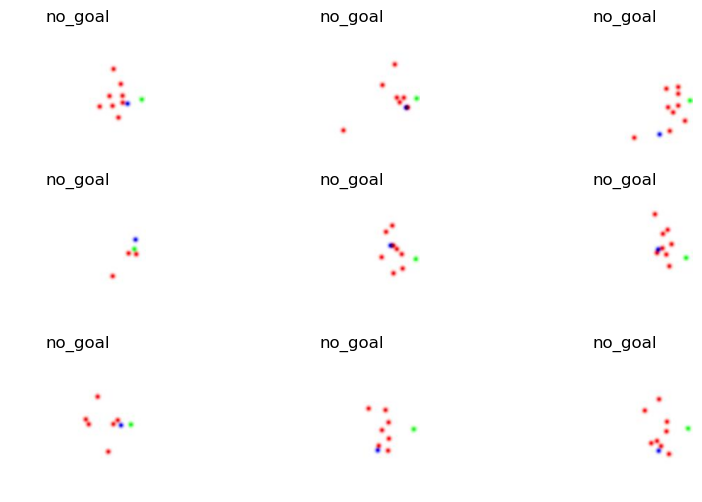

In [5]:
dls.show_batch(max_n=9, figsize=(10, 6))

In [34]:
def conv(ni, nf, ks=3, act=True):
    layers = [
        nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    ]
    if act:
        layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

def simple_cnn():
    return sequential(
        conv(3, 8, ks=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 128),
        conv(128, 256),
        conv(256, 512),
        conv(512, 2, act=False),
        Flatten()
    )

def fit(epochs=1, lr=0.06):
    learn = Learner(
        dls, simple_cnn(),
        loss_func=F.cross_entropy,           
        metrics=(RocAucBinary(), BrierScore()), 
        cbs=ActivationStats(with_hist=True)
    )
    learn.fit_one_cycle(epochs, lr)
    return learn

In [35]:
from fastai.vision.all import *
learn = fit(10)

/Users/rook/miniconda/envs/soccer_analytics/lib/python3.11/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,roc_auc_score,brier_score_loss,time
0,0.269568,0.284976,0.773752,0.101034,01:04
1,0.274947,0.284886,0.769220,0.103812,01:04
2,0.263334,0.273103,0.785401,0.096254,01:05
3,0.269220,0.273323,0.781911,0.096810,01:05
4,0.260135,0.310177,0.782168,0.119262,01:05
5,0.245372,0.276031,0.792474,0.097810,01:05
6,0.264436,0.273179,0.794799,0.100700,01:04
7,0.272747,0.269856,0.795295,0.096921,01:05
8,0.252478,0.268660,0.796468,0.098588,01:05
9,0.245019,0.269946,0.795559,0.097477,01:05


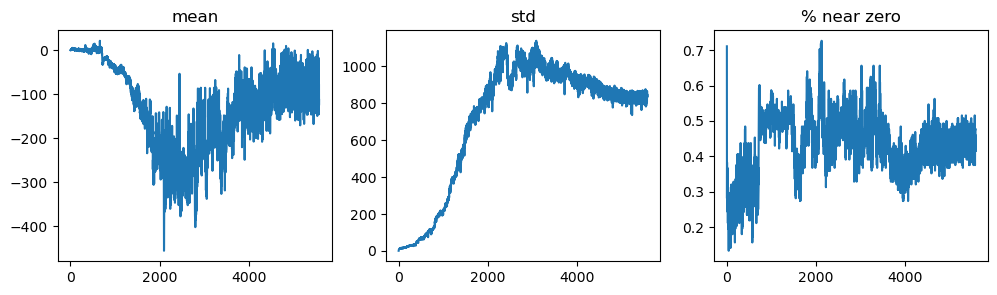

In [36]:
learn.activation_stats.plot_layer_stats(-2)

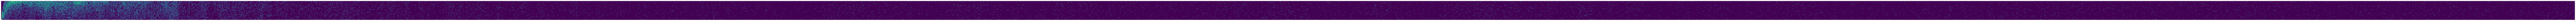

In [45]:
learn.activation_stats.color_dim(-2, figsize=(300, 200))